In [75]:
import torch
import torchvision
import torchvision.models as models
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc; gc.enable()
import pandas as pd
from torch.utils.data import Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.layers import Dense
from torchvision import transforms

In [76]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
# keras imports
# from keras.applications.vgg16 import VGG16, preprocess_input
# from keras.applications.vgg19 import VGG19, preprocess_input
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
# from keras.applications.mobilenet import MobileNet, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from keras.preprocessing import image
# from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input
# other imports
from sklearn.preprocessing import LabelEncoder
import numpy as np
import glob
import cv2
import h5py
import os
import json
import datetime
import time
# load the user configs
with open('conf/conf.json') as f:    
    config = json.load(f)
# config variables
model_name = config["model"]
weights = config["weights"]
include_top = config["include_top"]
train_path = config["train_path"]
features_path = config["features_path"]
labels_path = config["labels_path"]
test_size = config["test_size"]
results = config["results"]
model_path = config["model_path"]
# start time
print ("[STATUS] start time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
start = time.time()
# create the pretrained models
# check for pretrained weight usage or not
# check for top layers to be included or not
if model_name == "vgg16":
    base_model = VGG16(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224, 224)
elif model_name == "vgg19":
    base_model = VGG19(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224, 224)
elif model_name == "resnet50":
    base_model = keras.applications.ResNet50(include_top=False, weights=weights)
    model = base_model
#     model = Model(input=base_model.input, output=base_model.layers[-1].output)
    image_size = (224, 224)
elif model_name == "inceptionv3":
    base_model = InceptionV3(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
    model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
    image_size = (299, 299)
elif model_name == "inceptionresnetv2":
    base_model = InceptionResNetV2(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
#     model = Model(input=base_model.input, output=base_model.layers[-1].output)
    image_size = (299, 299)
elif model_name == "mobilenet":
    base_model = MobileNet(include_top=include_top, weights=weights, input_tensor=Input(shape=(224,224,3)), input_shape=(224,224,3))
    model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
    image_size = (224, 224)
elif model_name == "xception":
    base_model = Xception(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
    image_size = (299, 299)
else:
    base_model = None
print ("[INFO] successfully loaded base model and model...")


[STATUS] start time - 2019-08-23 14:29


/Users/flatironschool/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


[INFO] successfully loaded base model and model...


In [77]:
def getRadius(img):
#     print(type(img.shape))
    circles = cv2.HoughCircles(img,3,1,max(img.shape)/2,param1=50,param2=30,minRadius= int(max(img.shape)/6),maxRadius=max(img.shape))
    return circles[0][0][2]

In [78]:
original_dataset_dir = '/Users/flatironschool/Documents/Kaggle/Kaggle-DR-detection/'
train_dir = original_dataset_dir+'dataset/train_images/'
#read in table with image ids and retinopathy severity rating for associated image
labels = pd.read_csv(original_dataset_dir + 'train.csv')

In [13]:
#one-hot encode retinopathy severity
pd_diagnoses = pd.get_dummies(labels['diagnosis'])

In [79]:
diagnoses = keras.utils.to_categorical(labels['diagnosis'])

In [15]:
labels_minus_diagnosis = labels.drop(columns = ['diagnosis'])
dummy_labels = pd.concat([labels_minus_diagnosis,pd_diagnoses], axis = 1)

In [17]:
dummy_labels=dummy_labels.set_index('id_code')

In [18]:
t = dummy_labels.transpose()
t_dict = t.to_dict()

In [9]:
sm_path = train_dir + '/sm'
imgs = {}

In [10]:
smudge = []

In [11]:
for img in os.listdir(train_dir):
    if img.endswith('.png'):
        img_array = cv2.imread(os.path.join(train_dir,img))
        #crop each image to 80% of fundus diameter
        try:
            r = getRadius(img_array)
            crop_r = round(r*0.8) 
        except:
            crop_r = (img_array.shape[1]/2)*0.8
            
        center_x = int(img_array.shape[1]/2)
        center_y = int(img_array.shape[0]/2)
    
        left_border = int(center_x - crop_r)
        right_border = int(center_x + crop_r)
        upper_border = int(center_y - crop_r)
        lower_border = int(center_y + crop_r)
    
        if left_border < 0:
            difference = 0- left_border
            left_border = 0
            right_border -=difference
            upper_border += difference
            lower_border -= difference
        if upper_border < 0:
            difference = 0- upper_border
            upper_border = 0
            lower_border -= difference
            left_border += difference
            right_border -= difference

        cropped = img_array[upper_border:lower_border, left_border:right_border]
        #resize image to resnet's expected input size
        a = cv2.resize(cropped, (224,224), interpolation = cv2.INTER_CUBIC)
#         lab = cv2.cvtColor(a, cv2.COLOR_BGR2LAB)
#         lab_planes = cv2.split(lab)
#         clahe = cv2.createCLAHE(clipLimit= 1,tileGridSize=(round(a.shape[0]/6),round(a.shape[1]/6)))
#         lab_planes[0] = clahe.apply(lab_planes[0])
#         lab = cv2.merge(lab_planes)
#         a = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
       
#         a =cv2.medianBlur(a,5)
#         a=cv2.addWeighted(a, 4, cv2.GaussianBlur(a,(0,0), 30), -4, 128)
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        imgs[img[:-4]] = a
        gc.collect()
    
#         os.chdir(sm_path)
#         cv2.imwrite("sm"+"_"+img ,a)
#         os.chdir(path)   
#     print(ctr)

In [19]:
#generate arrays so that severity ratings have same order as their associated images
ordered_imgs = []
label_vectors = []
for key in imgs.keys():
    ordered_imgs.append(imgs[key])
    lbls = []
    for k in t_dict[key]:
        lbls.append(t_dict[key][k])
    label_vectors.append(lbls)


In [97]:
vgg19 = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 34s 0us/step


In [105]:
vgg19.output_shape[1]

In [109]:
input_shape = vgg19.output_shape
model = keras.models.Sequential()
model.add(vgg19)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(5,activation = 'softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [113]:
out = vgg19.output
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = 5
predictions = Dense(total_classes, activation='softmax')(out)

model = keras.models.Model(inputs=vgg19.input, outputs=predictions)

In [81]:
#instantiate pre-trained ResNet model
res_fifty = keras.applications.ResNet50(include_top=False, weights='imagenet')

/Users/flatironschool/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [121]:
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df_layers = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
df_layers

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1d969ee80>,input_6,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1da35a0f0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1da35ac50>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1da3a3b38>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1da388208>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1da41c438>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1cf78f7f0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cf78f7b8>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cf6d8748>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cf6cc1d0>,block3_conv3,False


In [99]:
p = 175*0.8
cnt = 0
set_trainable = False
for layer in vgg19.layers:
    if 'block4' in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [74]:
ordered_imgs[0].shape

(224, 224, 3)

In [95]:
import pydot
import graphviz
keras.utils.plot_model(res_fifty, to_file = 'res_fifty.png')

In [114]:
datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range = 180,horizontal_flip = True, vertical_flip = True, data_format = 'channels_last')
batch_size = 20
# datagen.fit(ordered_imgs)
 
train_generator = datagen.flow(
    np.asarray(ordered_imgs),
    label_vectors,
    batch_size=batch_size,
    shuffle = False)

train_steps_per_epoch = len(ordered_imgs) // batch_size
model.compile('Adam', loss = 'categorical_crossentropy')
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=15, verbose=1)

Epoch 1/15
184/184 [==============================] - 3090s 17s/step - loss: 8.1736
Epoch 2/15
184/184 [==============================] - 68943s 375s/step - loss: 8.1729
Epoch 3/15
184/184 [==============================] - 3196s 17s/step - loss: 8.1729
Epoch 4/15
184/184 [==============================] - 2988s 16s/step - loss: 8.1729
Epoch 5/15
184/184 [==============================] - 2942s 16s/step - loss: 8.1729
Epoch 6/15
184/184 [==============================] - 19444s 106s/step - loss: 8.1729
Epoch 7/15
184/184 [==============================] - 2856s 16s/step - loss: 8.1729
Epoch 8/15
184/184 [==============================] - 2805s 15s/step - loss: 8.1729
Epoch 9/15
184/184 [==============================] - 2781s 15s/step - loss: 8.1729
Epoch 10/15
184/184 [==============================] - 2780s 15s/step - loss: 8.1729
Epoch 11/15
184/184 [==============================] - 2779s 15s/step - loss: 8.1729
Epoch 12/15
184/184 [==============================] - 2772s 15s/step 

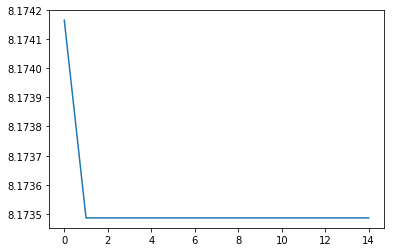

In [118]:
plt.plot(history.history['loss'])
plt.savefig('loss_20190824')

In [123]:
model.layers[21].output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, ?, ?, 512) dtype=float32>

In [129]:
# from keras import backend as K
get_last_pretrained_layer = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()],
                                  [model.layers[21].output])


In [137]:
get_last_pretrained_layer(np.asarray(ordered_imgs[0:3]))[0].shape

(3, 7, 7, 512)

In [157]:
len(ordered_imgs)

3662

In [193]:
train_features = np.zeros(shape=(len(ordered_imgs), 7, 7, 512))
train_labels = np.zeros(shape=(len(ordered_imgs),5))

In [195]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = get_last_pretrained_layer(inputs_batch)[0]
    train_features[i : i + len(inputs_batch)] = features_batch 
    train_labels[i : i +len(inputs_batch)] = labels_batch
    i+= len(inputs_batch)
    print(i)
    print(i>len(ordered_imgs))
    if i+len(inputs_batch) > len(ordered_imgs):
        print('beep')
        break
# train_features = np.reshape(train_features, (len(ordered_imgs), 7 * 7 * 512))

20
False
40
False
60
False
80
False
100
False
120
False
140
False
160
False
180
False
200
False
220
False
240
False
260
False
280
False
300
False
320
False
340
False
360
False
380
False
400
False
420
False
440
False
460
False
480
False
500
False
520
False
540
False
560
False
580
False
600
False
620
False
640
False
660
False
680
False
700
False
720
False
740
False
760
False
780
False
800
False
820
False
840
False
860
False
880
False
882
False
902
False
922
False
942
False
962
False
982
False
1002
False
1022
False
1042
False
1062
False
1082
False
1102
False
1122
False
1142
False
1162
False
1182
False
1202
False
1222
False
1242
False
1262
False
1282
False
1302
False
1322
False
1342
False
1362
False
1382
False
1402
False
1422
False
1442
False
1462
False
1482
False
1502
False
1522
False
1542
False
1562
False
1582
False
1602
False
1622
False
1642
False
1662
False
1682
False
1702
False
1722
False
1742
False
1762
False
1782
False
1802
False
1822
False
1842
False
1862
False
1882
False
1902
Fals

In [196]:
train_features = np.reshape(train_features, (len(ordered_imgs), 7 * 7 * 512))

In [197]:
indices = np.random.choice(train_features.shape[0], len(ordered_imgs)//5, replace=False)
features = train_features[indices, :]
tlabels = train_labels[indices,:]
i,j = np.where(train_labels==1)
t_labels = j[indices]

In [204]:
from sklearn.multiclass import OutputCodeClassifier as occ
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(train_features,j,test_size = 0.1)
clf = occ(SVC(random_state=69), random_state= 420)
clf.fit(features_train, labels_train)


OutputCodeClassifier(code_size=1.5,
           estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=69,
  shrinking=True, tol=0.001, verbose=False),
           n_jobs=None, random_state=420)

In [199]:
test_indices = np.random.choice(train_features.shape[0], len(ordered_imgs)//10, replace=False)
test_features = train_features[test_indices, :]
test_labels = j[test_indices]

In [200]:
test_ouput = clf.predict(features_test)

In [205]:
clf.score(features_test,labels_test)

0.5204359673024523

occ produces 0.63 accuracy w/ 3662//5 train images, frozen weights